# import imprortant library


In [50]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import cv2
import cv2.cuda
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image
import torch
import warnings
warnings.filterwarnings('ignore')
import torchvision.models as models
from sklearn.model_selection import KFold 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch.nn as nn
from typing import Any, List
import torchvision
from torch import optim , autocast
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import cv2
from torch.cuda.amp import GradScaler
from torchvision import transforms, datasets
from collections import Counter
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# get CUDA information


In [51]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

# Get the number of CUDA devices
num_devices = torch.cuda.device_count()
print("Number of CUDA devices:", num_devices)

# Get information about each CUDA device
for i in range(num_devices):
    device = torch.cuda.get_device_name(i)
    print("CUDA Device {}: {}".format(i, device))

del num_devices

CUDA is available
Number of CUDA devices: 1
CUDA Device 0: NVIDIA GeForce RTX 3080 Laptop GPU


# load dataset


In [52]:
orginalDataset = pd.read_pickle("../datasets/LSWMD.pkl")
orginalDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


# squeeze failureType


In [53]:
f_squeeze = lambda x: str(np.squeeze(x))
orginalDataset["failureType"] = orginalDataset["failureType"].map(f_squeeze)
del f_squeeze

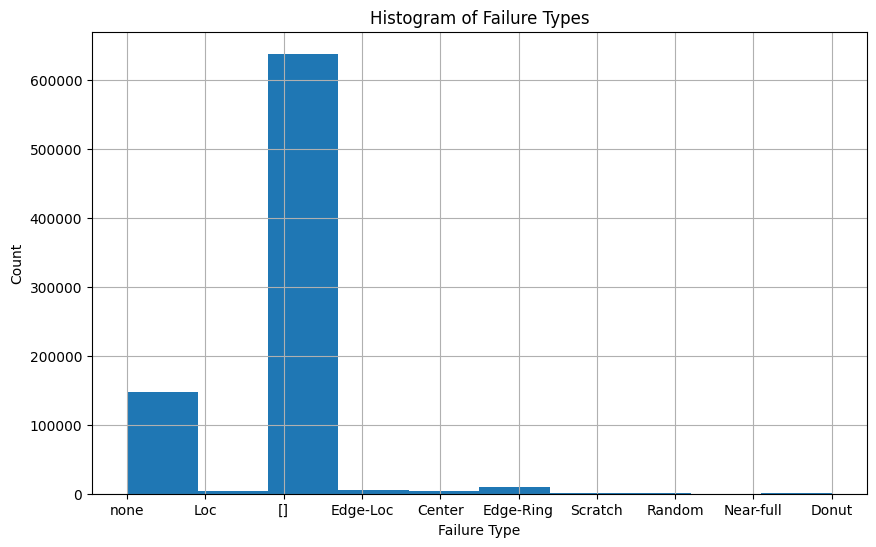

In [54]:
plt.figure(figsize=(10, 6))
orginalDataset['failureType'].hist()

plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Histogram of Failure Types')
plt.show()

# drop the row data with no specified label


In [55]:
eliminate_list = ["none", "[]"]
df_with_label = orginalDataset.query(f"failureType not in {eliminate_list}")
print(f"{len(df_with_label)}")
print("Label list: ", df_with_label["failureType"].unique())
df_with_label.head(3)
del eliminate_list

25519
Label list:  ['Loc' 'Edge-Loc' 'Center' 'Edge-Ring' 'Scratch' 'Random' 'Near-full'
 'Donut']


# drop unwanted columns


In [56]:
df_with_label = df_with_label.drop(
    ["waferIndex", "dieSize", "lotName", "waferIndex", "trianTestLabel"], axis=1
)
df_with_label.head()

,waferMap,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc


# reset index


In [57]:
df_with_label.reset_index(drop=True, inplace=True)
df_with_label.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc


# show samples of wafermap


In [58]:
for i in range(1000):
    item = np.array(df_with_label.waferMap[i], dtype=np.uint8)
    image = Image.fromarray(item)
    image_name = f"images/image_{str(i)}_{df_with_label.failureType[i]}.png"
    image.save(image_name)

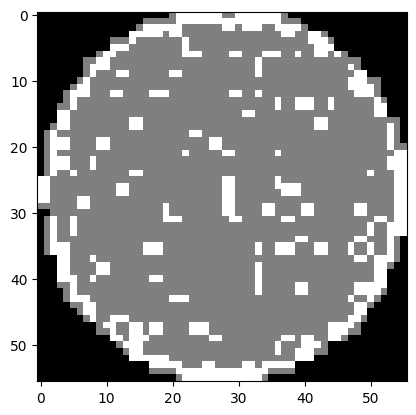

In [59]:
def convertToRGB(x):
    x[x == 0] = 0
    x[x == 1] = 127
    x[x == 2] = 255
    return cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)

image_name = f"images/image_891_Edge-Ring.png"
img = Image.open(image_name)
rows = []
resized_image_width = 56
resized_image_height = 56
new_row = {  'waferMap': np.array(img) }
rows.append(new_row)
df = pd.DataFrame(rows, columns=['waferMap'])
df["waferMap"] = df["waferMap"].apply(
    lambda x: np.array(
        Image.fromarray(x.astype("uint8")).resize(
            (resized_image_width, resized_image_height)
        )
    )
    )

df["waferMap"] = df.waferMap.apply(convertToRGB)
item = df.iloc[0]
image1 = np.array(item.waferMap, dtype=np.uint8)
plt.imshow(image1)
plt.show()

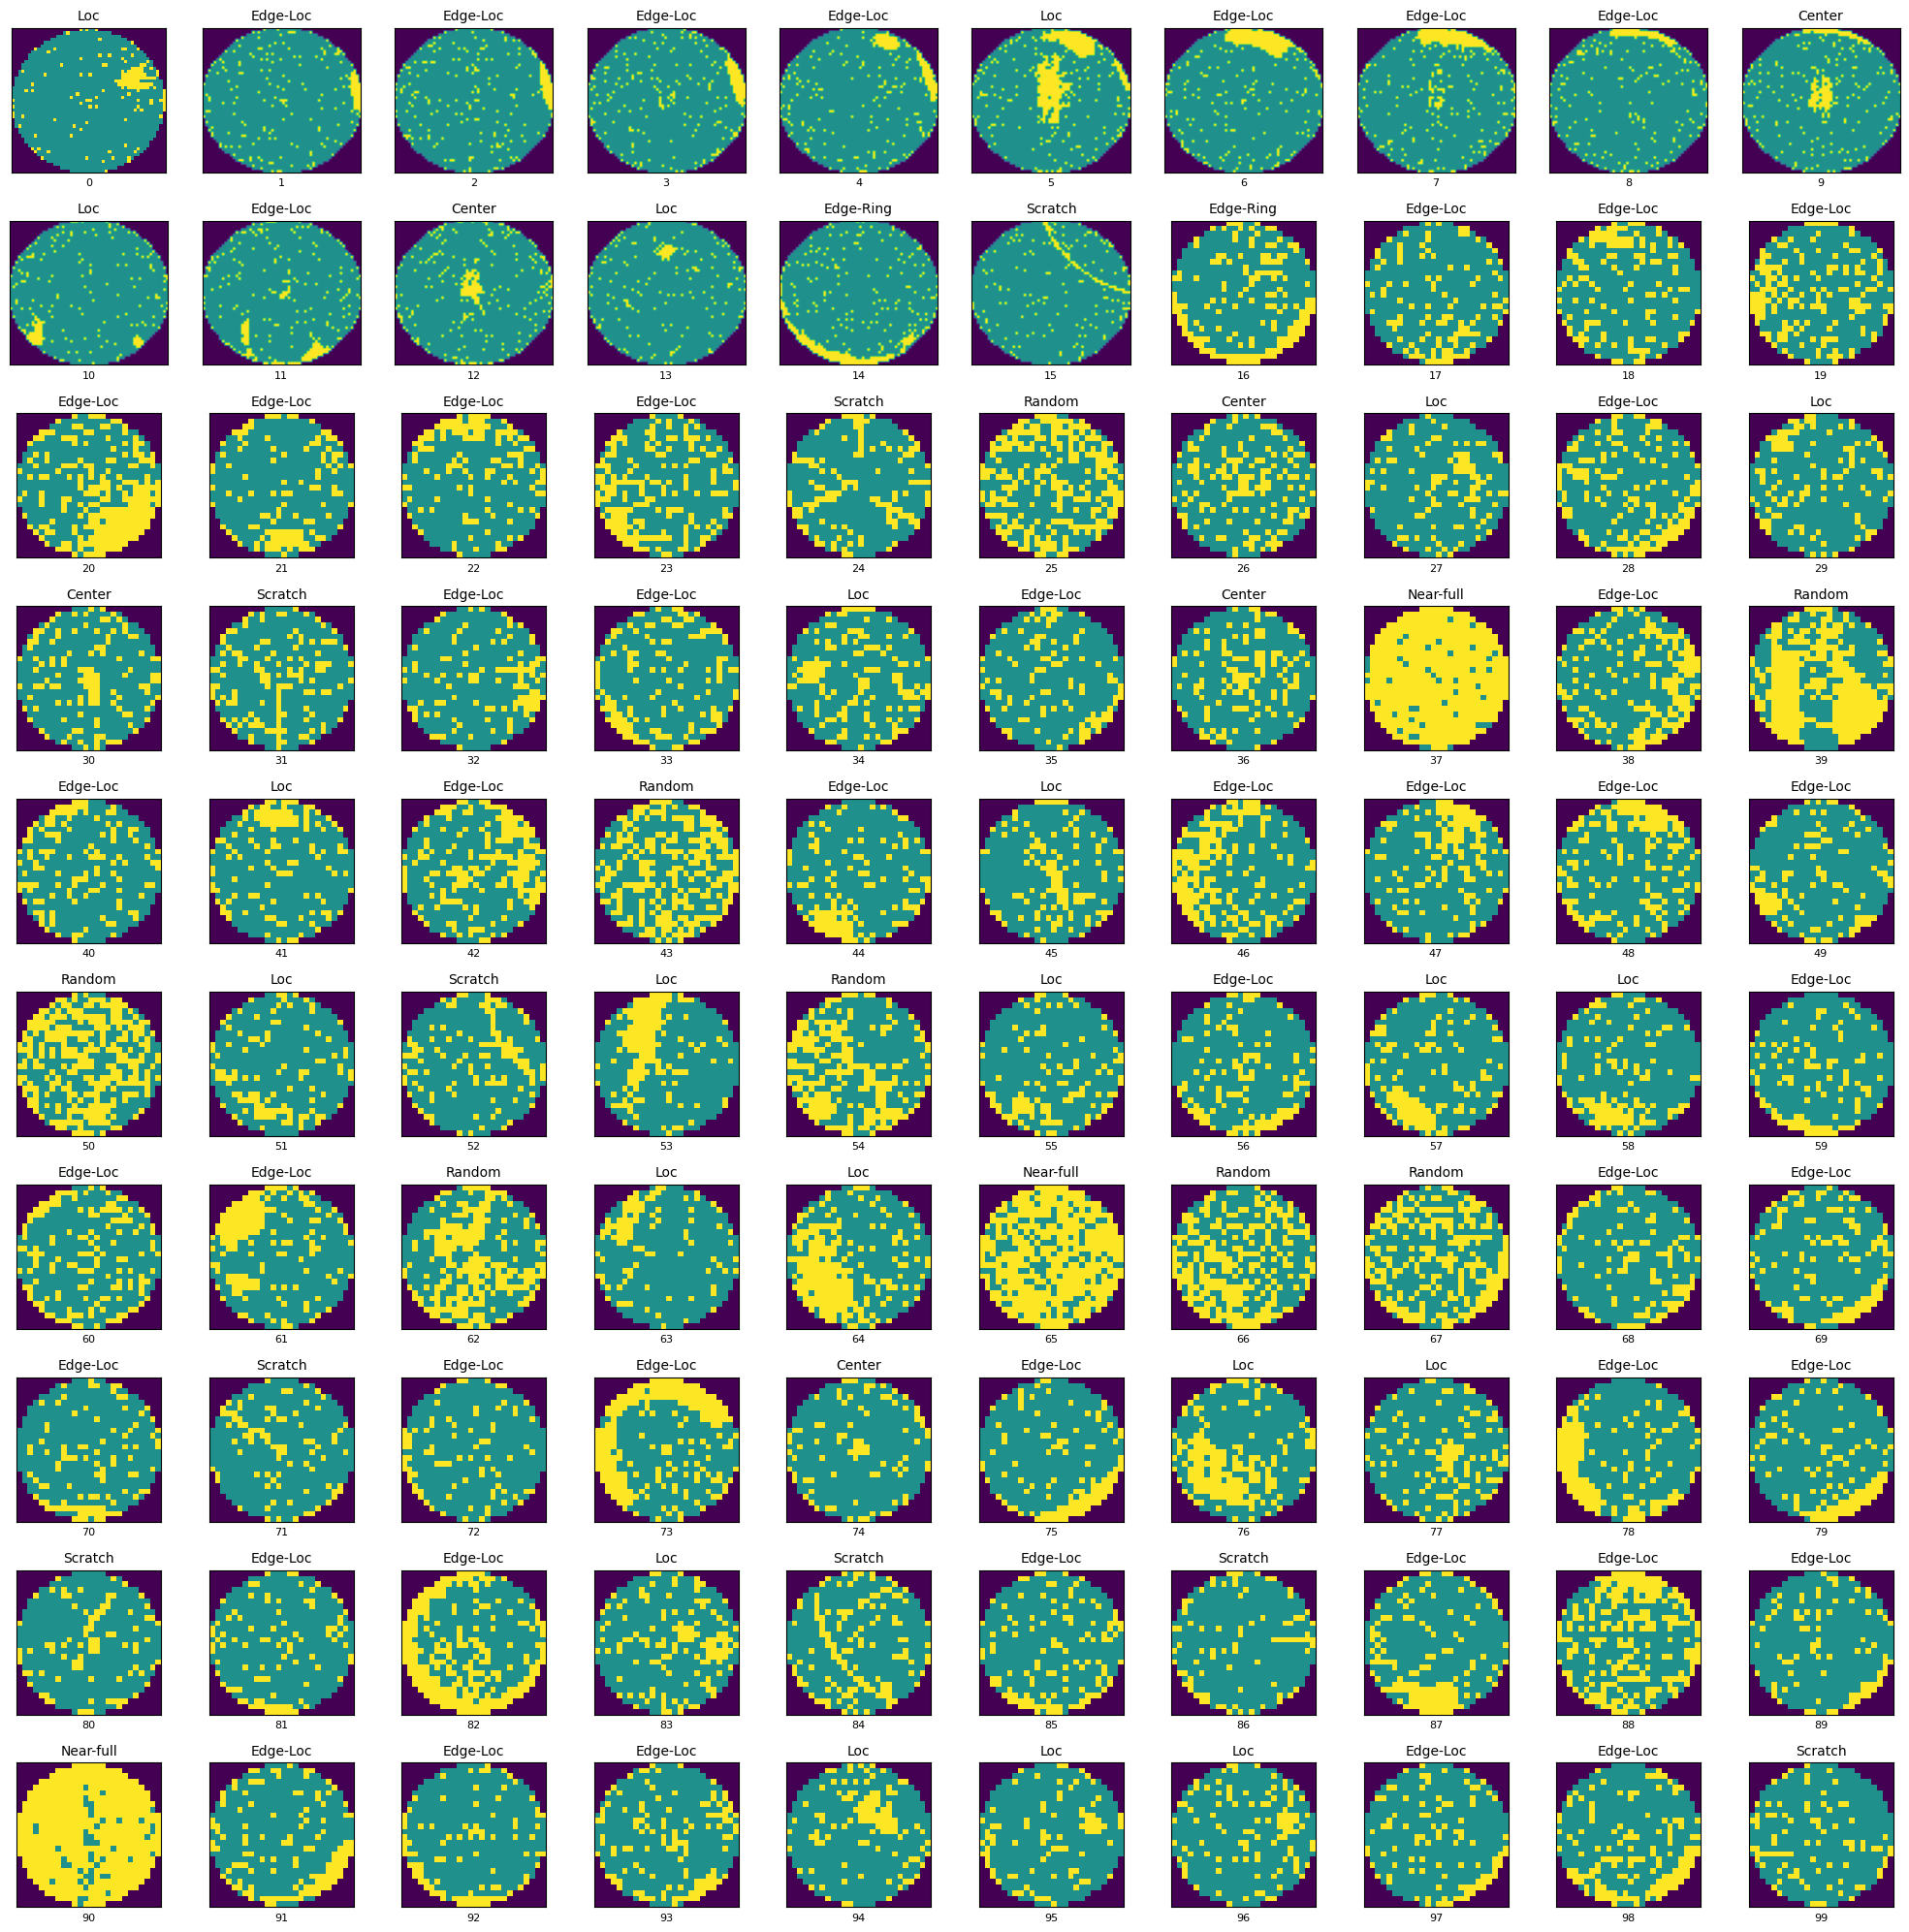

In [60]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
ax = ax.ravel(order="C")
for i in range(100):
    img = df_with_label.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_with_label.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_with_label.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [61]:
failure_type_counts = df_with_label["failureType"].value_counts()
failure_type_counts

failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: count, dtype: int64

In [62]:
x_pt_file = torch.load("datasets/x.pt")
y_pt_file = torch.load("datasets/y.pt")

In [63]:
ignoreList = ['C','D','EL','ER','L','N','NF','R','S']
multiple_data = []
for i, tensor in enumerate(x_pt_file):
    faultType = str(np.squeeze(y_pt_file[i]))
    if faultType not in ignoreList:
        new_row = {
    'waferMap': tensor.cpu().numpy(),
    'dieSize': 1.0,
    'lotName': 'value2',
    'waferIndex': 2.0,
    'trianTestLabel': 'value3',
    'failureType': faultType
}
    multiple_data.append(new_row)
multiple_new_df = pd.DataFrame(multiple_data, columns=['waferMap', 'dieSize', 'lotName','waferIndex','trianTestLabel','failureType'])
multiple_new_df.info()
del ignoreList, multiple_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38015 entries, 0 to 38014
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        38015 non-null  object 
 1   dieSize         38015 non-null  float64
 2   lotName         38015 non-null  object 
 3   waferIndex      38015 non-null  float64
 4   trianTestLabel  38015 non-null  object 
 5   failureType     38015 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.7+ MB


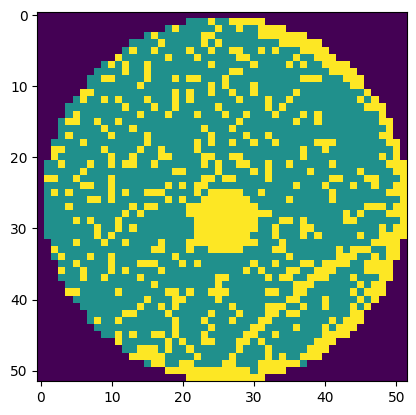

Faulty case : C+EL+S 


In [64]:
item = multiple_new_df.iloc[1000]
image1 = np.array(item.waferMap, dtype=np.uint8)
plt.imshow(image1)
plt.show()

# check faulty case
print("Faulty case : {} ".format(item.failureType))
del item, image1

In [65]:
concatenated_df = pd.concat([df_with_label, multiple_new_df], ignore_index=True)

In [66]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63534 entries, 0 to 63533
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        63534 non-null  object 
 1   failureType     63534 non-null  object 
 2   dieSize         38015 non-null  float64
 3   lotName         38015 non-null  object 
 4   waferIndex      38015 non-null  float64
 5   trianTestLabel  38015 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.9+ MB


# failureType and counts


In [67]:
failure_type_counts = concatenated_df["failureType"].value_counts()
failure_type_counts

failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
L+S          4015
D+S          4000
Loc          3593
C+EL+S       2000
EL+L+S       2000
C+S          2000
ER+S         2000
Scratch      1193
C+ER+S       1000
EL+S         1000
ER+L         1000
EL+L         1000
D+L          1000
D+L+S        1000
D+ER+L       1000
D+L+ER+S     1000
D+EL+L       1000
D+L+EL+S     1000
C+EL         1000
D+ER+S       1000
D+EL         1000
D+EL+S       1000
C+L          1000
C+L+S        1000
C+ER+L       1000
C+L+ER+S     1000
C+EL+L       1000
C+L+EL+S     1000
C+ER         1000
D+ER         1000
Random        866
Donut         555
Near-full     149
Name: count, dtype: int64

# find waferMap dimentions with counts


In [68]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return str(dim0) + " x " + str(dim1)


concatenated_df["dimensions"] = concatenated_df.waferMap.apply(find_dim)
dimensions_counts = concatenated_df["dimensions"].value_counts()
for dimension, count in dimensions_counts.items():
    print(f"Dimension: {dimension}, Count: {count}")

Dimension: 52 x 52, Count: 38017
Dimension: 25 x 27, Count: 2900
Dimension: 38 x 36, Count: 2127
Dimension: 53 x 52, Count: 1519
Dimension: 63 x 62, Count: 1424
Dimension: 39 x 37, Count: 1015
Dimension: 26 x 26, Count: 877
Dimension: 30 x 34, Count: 710
Dimension: 35 x 31, Count: 648
Dimension: 44 x 41, Count: 600
Dimension: 29 x 26, Count: 555
Dimension: 41 x 41, Count: 527
Dimension: 69 x 73, Count: 484
Dimension: 107 x 150, Count: 470
Dimension: 41 x 42, Count: 465
Dimension: 46 x 46, Count: 454
Dimension: 43 x 42, Count: 453
Dimension: 39 x 31, Count: 453
Dimension: 34 x 34, Count: 442
Dimension: 32 x 29, Count: 413
Dimension: 35 x 40, Count: 405
Dimension: 33 x 29, Count: 401
Dimension: 26 x 30, Count: 363
Dimension: 41 x 33, Count: 307
Dimension: 25 x 26, Count: 267
Dimension: 27 x 25, Count: 257
Dimension: 48 x 52, Count: 250
Dimension: 40 x 40, Count: 242
Dimension: 56 x 41, Count: 235
Dimension: 33 x 33, Count: 231
Dimension: 31 x 31, Count: 231
Dimension: 38 x 38, Count: 222

# convert failureType to numbers


In [69]:
label_list = concatenated_df["failureType"].unique()
class2idx = {label: idx for idx, label in enumerate(label_list)}
class2idx

{'Loc': 0,
 'Edge-Loc': 1,
 'Center': 2,
 'Edge-Ring': 3,
 'Scratch': 4,
 'Random': 5,
 'Near-full': 6,
 'Donut': 7,
 'C+EL+S': 8,
 'C+EL': 9,
 'C+ER+S': 10,
 'C+ER': 11,
 'C+L+EL+S': 12,
 'C+EL+L': 13,
 'C+L+ER+S': 14,
 'C+ER+L': 15,
 'C+L+S': 16,
 'C+L': 17,
 'C+S': 18,
 'D+EL+S': 19,
 'D+EL': 20,
 'D+ER+S': 21,
 'D+ER': 22,
 'D+L+EL+S': 23,
 'D+EL+L': 24,
 'D+L+ER+S': 25,
 'D+ER+L': 26,
 'D+L+S': 27,
 'D+L': 28,
 'D+S': 29,
 'EL+L+S': 30,
 'EL+L': 31,
 'ER+L': 32,
 'L+S': 33,
 'EL+S': 34,
 'ER+S': 35}

# New column → encoded_labels


In [70]:
concatenated_df["failureNumber"] = concatenated_df["failureType"].replace(class2idx)
concatenated_df.head()

,waferMap,failureType,dieSize,lotName,waferIndex,trianTestLabel,dimensions,failureNumber
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,NaN,NaN,NaN,NaN,45 x 48,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,NaN,NaN,NaN,NaN,53 x 58,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,NaN,NaN,NaN,NaN,53 x 58,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,NaN,NaN,NaN,NaN,53 x 58,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,NaN,NaN,NaN,NaN,53 x 58,1


# resize wafermap


In [71]:
resized_image_width = 56
resized_image_height = 56
concatenated_df["waferMap"] = concatenated_df["waferMap"].apply(
    lambda x: np.array(
        Image.fromarray(x.astype("uint8")).resize(
            (resized_image_width, resized_image_height)
        )
    )
)

# show sample


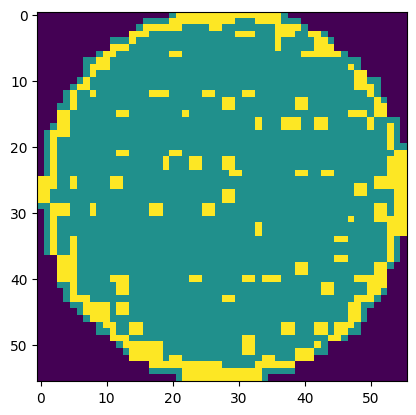

Faulty case : Edge-Ring 


In [72]:
item = concatenated_df.iloc[1000]
image1 = np.array(item.waferMap, dtype=np.uint8)
plt.imshow(image1)
plt.show()

# check faulty case
print("Faulty case : {} ".format(item.failureType))



# rotate images


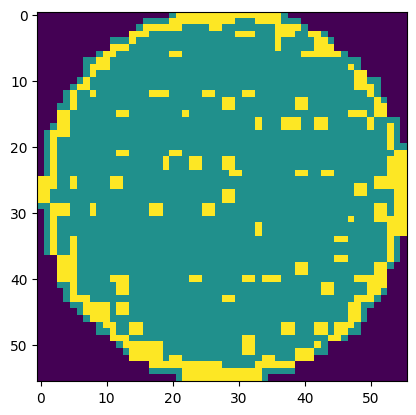

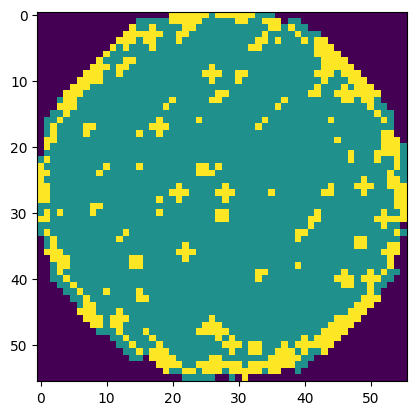

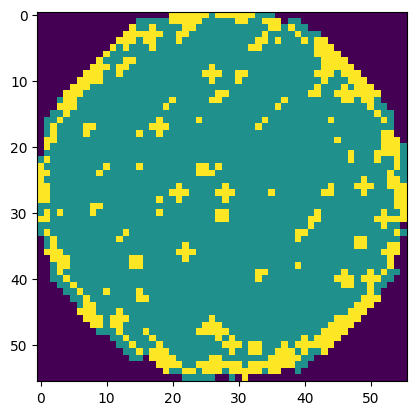

In [73]:
item = concatenated_df.iloc[1000]
image1 = Image.fromarray(item.waferMap.astype("uint8"))
plt.imshow(image1)
plt.show()
angle = 45

rotated_img = image1.rotate(angle, expand=False)
plt.imshow(rotated_img)
plt.show()
pixels = image1.load()

# Iterate over each pixel in the image
for i in range(image1.size[0]):
    for j in range(image1.size[1]):
        # Check if the pixel color is (0, 1)
        if pixels[i, j] == (0, 1):
            # Rotate the pixel by the specified angle
            rotated_pixel = pixels[i, j]
            rotated_pixel = rotated_pixel.rotate(angle)

            # Update the pixel value in the image
            pixels[i, j] = rotated_pixel
rotated_img = image1.rotate(angle, expand=False)
plt.imshow(rotated_img)
plt.show()

In [74]:
maxCount = 0
maxFaliure = ""
for key, disc in failure_type_counts.items():
    if maxCount < disc:
        maxCount = disc
        maxFaliure = key

print("the ", maxFaliure, "has the maximum of", maxCount)

the  Edge-Ring has the maximum of 9680


# conver waferMap to RGB


In [75]:
def convertToRGB(x):
    x[x == 0] = 0
    x[x == 1] = 127
    x[x == 2] = 255
    return cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)


concatenated_df["waferMap"] = concatenated_df.waferMap.apply(convertToRGB)

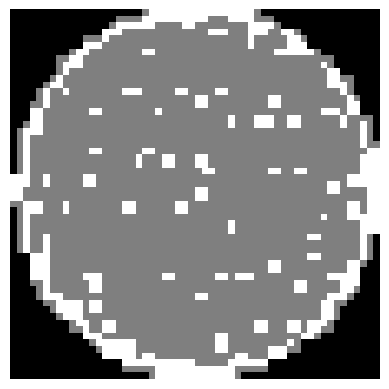

(56, 56, 3)


In [76]:
item = concatenated_df.iloc[1000]
image1 = item.waferMap.astype("uint8")
plt.imshow(image1)
plt.axis('off')
plt.show()
print(image1.shape)

In [77]:
# transform = transforms.Compose(
#     [
#         transforms.ToPILImage(),
#         transforms.RandomVerticalFlip(p=0.5),
#     ]
# )
# item = concatenated_df.iloc[1000]
# image1 = item.waferMap.astype("uint8")
# plt.imshow(image1)
# plt.show()
# print(image1.shape)

# transformed_image = transform(image1)
# plt.imshow(transformed_image)
# plt.show()

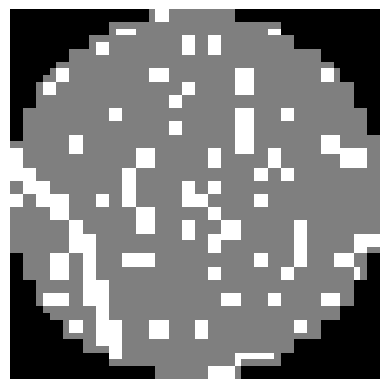

Faulty case : Scratch 


In [78]:
filtered_df_1 = concatenated_df[concatenated_df['failureType'] == 'Scratch']
# filtered_df_2 = concatenated_df[concatenated_df['failureType'] == 'Loc']
# filtered_df_3 = concatenated_df[concatenated_df['failureType'] == 'Edge-Ring']
# filtered_df_4 = concatenated_df[concatenated_df['failureType'] == 'Scratch']

item = filtered_df_1.iloc[20]
image1 = item.waferMap.astype("uint8")
plt.imshow(image1)
plt.axis('off')
plt.show()
print("Faulty case : {} ".format(item.failureType))

# item = filtered_df_2.iloc[1]
# image2 = item.waferMap.astype("uint8")
# plt.imshow(image2)
# plt.show()
# print("Faulty case : {} ".format(item.failureType))

# item = filtered_df_3.iloc[1]
# image3 = item.waferMap.astype("uint8")
# plt.imshow(image3)
# plt.show()
# print("Faulty case : {} ".format(item.failureType))

# item = filtered_df_4.iloc[1]
# image4 = item.waferMap.astype("uint8")
# plt.imshow(image4)
# plt.show()
# print("Faulty case : {} ".format(item.failureType))

# new_image = np.maximum(image1, image2)
# new_image = np.maximum(new_image, image3)
# new_image = np.maximum(new_image, image4)
# plt.imshow(new_image)
# plt.show()


In [79]:
new_df = pd.DataFrame(columns=['waferMap', 'failureType' , 'failureNumber'])
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Lambda(lambda x: np.array(x).reshape((1, resized_image_width, resized_image_height, 3))),
        transforms.Lambda(lambda x: torch.from_numpy(x)),
    ]
)
transformed_data = []
failure_counts = Counter(concatenated_df['failureType'])
max_failure_type, max_failure_count = failure_counts.most_common(1)[0]
for item in failure_counts:
    if (item != max_failure_type ):
        filtered_df = concatenated_df.loc[concatenated_df['failureType'] == item]
        num_transforms = int(np.ceil((max_failure_count - len(filtered_df)) / len(filtered_df)))
        for index, row in filtered_df.iterrows():
            image = row['waferMap']
            failure_type = row['failureType']
            failureNumber = row['failureNumber']
            for i in range(num_transforms):
                torch.manual_seed(i)
                transformed_image = transform(image)
                transformed_image_cuda = transformed_image.to(torch.device("cuda"))
                transformed_data.append({'waferMap': transformed_image_cuda, 'failureType': failure_type, 'failureNumber': failureNumber})

new_df = pd.DataFrame(transformed_data, columns=['waferMap', 'failureType', 'failureNumber'])
new_df.info();

del transformed_data



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305034 entries, 0 to 305033
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   waferMap       305034 non-null  object
 1   failureType    305034 non-null  object
 2   failureNumber  305034 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.0+ MB


In [80]:
failure_counts = Counter(new_df['failureType'])
failure_counts

Counter({'Scratch': 9544,
         'Near-full': 9536,
         'Random': 9526,
         'Donut': 9435,
         'C+EL': 9000,
         'C+ER+S': 9000,
         'C+ER': 9000,
         'C+L+EL+S': 9000,
         'C+EL+L': 9000,
         'C+L+ER+S': 9000,
         'C+ER+L': 9000,
         'C+L+S': 9000,
         'C+L': 9000,
         'D+EL+S': 9000,
         'D+EL': 9000,
         'D+ER+S': 9000,
         'D+ER': 9000,
         'D+L+EL+S': 9000,
         'D+EL+L': 9000,
         'D+L+ER+S': 9000,
         'D+ER+L': 9000,
         'D+L+S': 9000,
         'D+L': 9000,
         'EL+L': 9000,
         'ER+L': 9000,
         'EL+S': 9000,
         'Center': 8588,
         'L+S': 8030,
         'C+EL+S': 8000,
         'C+S': 8000,
         'D+S': 8000,
         'EL+L+S': 8000,
         'ER+S': 8000,
         'Loc': 7186,
         'Edge-Loc': 5189})

In [81]:
concatenated_df = concatenated_df.drop(["dimensions"], axis=1)

In [82]:
new_df_1 = pd.DataFrame(columns=['waferMap', 'failureType' , 'failureNumber'])
transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: np.array(x).reshape((1, resized_image_width, resized_image_height, 3))),
        transforms.Lambda(lambda x: torch.from_numpy(x)),
    ]
)
transformed_data = []
for index, row in concatenated_df.iterrows():
    image = row['waferMap']
    failure_type = row['failureType']
    failureNumber = row['failureNumber']
    transformed_image = transform(image)
    transformed_image_cuda = transformed_image.to(torch.device("cuda"))
    transformed_data.append({'waferMap': transformed_image_cuda, 'failureType': failure_type, 'failureNumber': failureNumber})

new_df_1 = pd.DataFrame(transformed_data, columns=['waferMap', 'failureType', 'failureNumber'])
print(new_df_1)
del transformed_data

                                                waferMap failureType  \
0      [[[tensor([0, 0, 0], device='cuda:0', dtype=to...         Loc   
1      [[[tensor([0, 0, 0], device='cuda:0', dtype=to...    Edge-Loc   
2      [[[tensor([0, 0, 0], device='cuda:0', dtype=to...    Edge-Loc   
3      [[[tensor([0, 0, 0], device='cuda:0', dtype=to...    Edge-Loc   
4      [[[tensor([0, 0, 0], device='cuda:0', dtype=to...    Edge-Loc   
...                                                  ...         ...   
63529  [[[tensor([0, 0, 0], device='cuda:0', dtype=to...        ER+S   
63530  [[[tensor([0, 0, 0], device='cuda:0', dtype=to...        ER+S   
63531  [[[tensor([0, 0, 0], device='cuda:0', dtype=to...        ER+S   
63532  [[[tensor([0, 0, 0], device='cuda:0', dtype=to...        ER+S   
63533  [[[tensor([0, 0, 0], device='cuda:0', dtype=to...        ER+S   

       failureNumber  
0                  0  
1                  1  
2                  1  
3                  1  
4                  1

In [83]:
merged_df = pd.concat([new_df_1, new_df], ignore_index=True)
merged_df.head()
del new_df_1, new_df

In [84]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368568 entries, 0 to 368567
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   waferMap       368568 non-null  object
 1   failureType    368568 non-null  object
 2   failureNumber  368568 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.4+ MB


In [85]:
failure_counts = Counter(merged_df['failureType'])
failure_counts

Counter({'Center': 12882,
         'L+S': 12045,
         'D+S': 12000,
         'Loc': 10779,
         'Scratch': 10737,
         'Random': 10392,
         'Edge-Loc': 10378,
         'C+EL+S': 10000,
         'C+EL': 10000,
         'C+ER+S': 10000,
         'C+ER': 10000,
         'C+L+EL+S': 10000,
         'C+EL+L': 10000,
         'C+L+ER+S': 10000,
         'C+ER+L': 10000,
         'C+L+S': 10000,
         'C+L': 10000,
         'C+S': 10000,
         'D+EL+S': 10000,
         'D+EL': 10000,
         'D+ER+S': 10000,
         'D+ER': 10000,
         'D+L+EL+S': 10000,
         'D+EL+L': 10000,
         'D+L+ER+S': 10000,
         'D+ER+L': 10000,
         'D+L+S': 10000,
         'D+L': 10000,
         'EL+L+S': 10000,
         'EL+L': 10000,
         'ER+L': 10000,
         'EL+S': 10000,
         'ER+S': 10000,
         'Donut': 9990,
         'Near-full': 9685,
         'Edge-Ring': 9680})

In [86]:
def subwafer(sw, label):
    Dim0 = np.size(sw, axis=1)
    Dim1 = np.size(sw, axis=2)
    sub_wafer = merged_df["waferMap"].values
    sw = sw.to(torch.device("cuda"))
    for i in range(len(merged_df)):
        a = np.array(merged_df.iloc[i, :]["waferMap"]).reshape((1, Dim0, Dim1, 3))
        waferMap = torch.from_numpy(a)
        waferMap = waferMap.to(torch.device("cuda"))
        sw = torch.cat([sw, waferMap])
        label.append(merged_df.iloc[i, :]["failureType"])
    x = sw[1:]
    y = np.array(label).reshape((-1, 1))
    del waferMap, sw
    return x, y

In [87]:
label0 = list()
failureTypeArray = merged_df["failureType"].values
for i in range(len(failureTypeArray)):
    label0.append(failureTypeArray[i])

In [88]:

wafer_maps = merged_df["waferMap"].values
tensor = torch.cat([x.unsqueeze(0) for x in wafer_maps], dim=0)
tensor = tensor.squeeze(1)


In [89]:
label =np.array(label0).reshape((-1, 1))

In [90]:
# labels = to_categorical(labels)
# wafer_tensors = torch.stack([torch.from_numpy(np.array(img)).type(torch.float32) for img in wafer_maps])
print("Wafer Tensors Shape:", tensor.shape)
print("Label Tensors Shape:", label.shape)

Wafer Tensors Shape: torch.Size([368568, 56, 56, 3])
Label Tensors Shape: (368568, 1)


In [91]:
wafer_tensors = tensor.permute(0, 3, 1, 2)

In [92]:
wafer_tensors.shape

torch.Size([368568, 3, 56, 56])

In [93]:
faulty_case = np.unique(label)
faulty_case

array(['C+EL', 'C+EL+L', 'C+EL+S', 'C+ER', 'C+ER+L', 'C+ER+S', 'C+L',
       'C+L+EL+S', 'C+L+ER+S', 'C+L+S', 'C+S', 'Center', 'D+EL', 'D+EL+L',
       'D+EL+S', 'D+ER', 'D+ER+L', 'D+ER+S', 'D+L', 'D+L+EL+S',
       'D+L+ER+S', 'D+L+S', 'D+S', 'Donut', 'EL+L', 'EL+L+S', 'EL+S',
       'ER+L', 'ER+S', 'Edge-Loc', 'Edge-Ring', 'L+S', 'Loc', 'Near-full',
       'Random', 'Scratch'], dtype='<U9')

In [94]:
for i, l in enumerate(faulty_case):
    label[label == l] = i
    print("i : {}, l : {}".format(i, l))


def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)


label_wm = _to_one_hot(torch.as_tensor(np.int64(label)), num_classes=36)

i : 0, l : C+EL
i : 1, l : C+EL+L
i : 2, l : C+EL+S
i : 3, l : C+ER
i : 4, l : C+ER+L
i : 5, l : C+ER+S
i : 6, l : C+L
i : 7, l : C+L+EL+S
i : 8, l : C+L+ER+S
i : 9, l : C+L+S
i : 10, l : C+S
i : 11, l : Center
i : 12, l : D+EL
i : 13, l : D+EL+L
i : 14, l : D+EL+S
i : 15, l : D+ER
i : 16, l : D+ER+L
i : 17, l : D+ER+S
i : 18, l : D+L
i : 19, l : D+L+EL+S
i : 20, l : D+L+ER+S
i : 21, l : D+L+S
i : 22, l : D+S
i : 23, l : Donut
i : 24, l : EL+L
i : 25, l : EL+L+S
i : 26, l : EL+S
i : 27, l : ER+L
i : 28, l : ER+S
i : 29, l : Edge-Loc
i : 30, l : Edge-Ring
i : 31, l : L+S
i : 32, l : Loc
i : 33, l : Near-full
i : 34, l : Random
i : 35, l : Scratch


In [95]:
print("Wafer Tensors Shape:", wafer_tensors.shape)

Wafer Tensors Shape: torch.Size([368568, 3, 56, 56])


In [96]:
torch.save(wafer_tensors, 'wafer_tensors.pt')

In [97]:
torch.save(label_wm, 'label_wm.pt')